In [1]:
import gymnasium as gym
from gymnasium import spaces
import pygame
import random
import math
import numpy as np
import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import collections
from collections import namedtuple, deque
import tqdm
import matplotlib.pyplot as plt
import random
class FlappyBirdEnv(gym.Env):
    metadata = {'render.modes': ['human']}

    

    def __init__(self):
        super(FlappyBirdEnv, self).__init__()
        self.action_space = spaces.Discrete(2)  # Actions: 0 = do nothing; 1 = flap
        self.observation_space = spaces.Box(
            low=np.array([0, -10, 0, 0, 0, 0]),  # Minimum values for each component
            high=np.array([480, 10, 640, 640, 480, 480]),  # Maximum values for each component
            dtype=np.float32  # Using float32 to accommodate the range and precision
        )

        pygame.init()
        self.screen = pygame.display.set_mode((640, 480))
        self.clock = pygame.time.Clock()
        self.font = pygame.font.Font(None, 36)

        # Game variables
        self.bird_y = 240
        self.bird_speed = 0
        self.gravity = 1
        self.flap_strength = -10
        self.game_over = False
        self.score = 0

        self.pipe_width = 80
        self.pipe_gap = 200
        self.pipe_speed = 4
        self.pipes = []
        # Spawn initial set of pipes to ensure always having at least 2 in front
        self.spawn_pipe()

    def spawn_pipe(self):
        # Define a new pipe based on the game's logic (random height, etc.)
        top_height = random.randint(50, 300)
        bottom_height = 480 - (top_height + self.pipe_gap)
    
        # Calculate the position for the new pipe
        # If there are already pipes, position the new one at a set distance from the last one
        # Otherwise, position it closer to introduce it as the second closest pipe initially
        if self.pipes:
            last_pipe_x = self.pipes[-1]['x']
            new_pipe_x = last_pipe_x + 300  # Spacing between pipes
        else:
            new_pipe_x = 640  # Initial position for the first pipe, or if no pipes exist
    
        # Add the new pipe to the list of pipes
        self.pipes.append({'x': new_pipe_x, 'top_height': top_height, 'bottom_height': bottom_height})
    
        # Ensure there's always a next pipe ready
        if len(self.pipes) < 2:
            self.spawn_pipe()  # Recursively spawn another pipe if less than two are present

    def update_pipes(self):
        # This method should be called at the start of each `step` to update the positions of pipes
        # and ensure there are always at least two pipes ahead
    
        # Move pipes
        for pipe in self.pipes:
            pipe['x'] -= self.pipe_speed
    
        # Remove pipes that have passed out of view
        self.pipes = [pipe for pipe in self.pipes if pipe['x'] > -self.pipe_width]
    
        # If there are less than 2 pipes ahead, spawn new ones
        while len([pipe for pipe in self.pipes if pipe['x'] >= 300]) < 2:
            self.spawn_pipe()
    
        # Update observations for closest and second closest pipes here if necessary

    def step(self, action):
        reward = 1  # Base reward for surviving a step
    
        # Apply the bird's action
        if action == 1:  # Bird flaps
            self.bird_speed = self.flap_strength
        else:  # Bird does nothing, gravity takes effect
            self.bird_speed += self.gravity
    
        # Ensure bird's speed stays within bounds
        self.bird_speed = max(self.bird_speed, -10)  # Max upward speed
        self.bird_speed = min(self.bird_speed, 10)  # Max downward speed
        self.bird_y += self.bird_speed
    
        # Update pipes: move them, remove off-screen pipes, and ensure there are always pipes ahead
        self.update_pipes()
    
        # Check for collisions and update the score
        bird_rect = pygame.Rect(300, self.bird_y - 10, 20, 20)  # Bird's position and size
        for pipe in self.pipes:
            if pipe['x'] < 300:  # Only consider pipes that the bird has already passed for scoring
                if 'scored' not in pipe:  # Ensure we only score once per pipe
                    self.score += 1
                    reward += 50  # Big reward for passing a pipe
                    pipe['scored'] = True  # Mark this pipe as scored
    
            # Check for collisions
            top_pipe_rect = pygame.Rect(pipe['x'], 0, self.pipe_width, pipe['top_height'])
            bottom_pipe_rect = pygame.Rect(pipe['x'], 480 - pipe['bottom_height'], self.pipe_width, pipe['bottom_height'])
            if bird_rect.colliderect(top_pipe_rect) or bird_rect.colliderect(bottom_pipe_rect):
                self.game_over = True
                reward = -100  # Penalty for hitting a pipe
                break
    
        # Check for out-of-bounds (too high or too low)
        if self.bird_y > 480 or self.bird_y < 0:
            self.game_over = True
            reward = -100  # Penalty for going out of bounds
    
        # Update the observation space for the next step
        observation = self.get_observation()
    
        return observation, reward, self.game_over, {}

    def reset(self):
        self.bird_y = 240
        self.bird_speed = 0
        self.game_over = False
        self.pipes.clear()
        self.spawn_pipe()
        self.score = 0
        return self.get_observation()

    def render(self, mode='human'):
        self.screen.fill((255, 255, 255))  # Clear screen
        pygame.draw.circle(self.screen, (255, 0, 0), (300, int(self.bird_y)), 10)  # Draw bird
    
        # First, determine the indexes of the closest and second closest pipes
        closest_pipe_index = None
        second_closest_pipe_index = None
        for i, pipe in enumerate(self.pipes):
            if pipe['x'] + self.pipe_width >= 300:  # The pipe is in front of or at the bird
                if closest_pipe_index is None:
                    closest_pipe_index = i
                elif second_closest_pipe_index is None:
                    second_closest_pipe_index = i
                else:
                    break  # We found the two closest pipes
    
        # Draw pipes with colors based on their status relative to the bird
        for i, pipe in enumerate(self.pipes):
            if i == closest_pipe_index:
                color = (255, 0, 0)  # Red for the closest pipe
            elif i == second_closest_pipe_index:
                color = (255, 255, 0)  # Yellow for the second closest pipe
            else:
                color = (0, 128, 0)  # Green for all other pipes
    
            pygame.draw.rect(self.screen, color, (pipe['x'], 0, self.pipe_width, pipe['top_height']))
            pygame.draw.rect(self.screen, color, (pipe['x'], 480 - pipe['bottom_height'], self.pipe_width, pipe['bottom_height']))
    
        # Display score, centered
        score_text = self.font.render(f"Score: {self.score}", True, (0, 0, 0))
        text_rect = score_text.get_rect(center=(320, 50))
        self.screen.blit(score_text, text_rect)
    
        pygame.display.flip()
        self.clock.tick(30)

    def close(self):
        pygame.display.quit()
        pygame.quit()

    def get_observation(self):
        # Initialize with maximum possible distances and zero heights
        distance_to_closest_pipe = 640  # Max screen width
        height_of_middle_of_closest_pipe = 0
        distance_to_second_closest_pipe = 640  # Max screen width
        height_of_middle_of_second_closest_pipe = 0
    
        # Calculate distances to all pipes that are in front of the bird
        pipes_in_front = [(pipe['x'] - 300, pipe) for pipe in self.pipes if pipe['x'] + self.pipe_width >= 300]
    
        # Sort the pipes in front by distance
        pipes_in_front.sort(key=lambda x: x[0])
    
        # Update distances and heights for the closest and second closest pipes
        if len(pipes_in_front) > 0:
            distance_to_closest_pipe, closest_pipe = pipes_in_front[0]
            height_of_middle_of_closest_pipe = closest_pipe['top_height'] + self.pipe_gap / 2
    
        if len(pipes_in_front) > 1:
            distance_to_second_closest_pipe, second_closest_pipe = pipes_in_front[1]
            height_of_middle_of_second_closest_pipe = second_closest_pipe['top_height'] + self.pipe_gap / 2
    
        # Construct and return the observation array
        return np.array([
            self.bird_y, self.bird_speed,
            distance_to_closest_pipe, distance_to_second_closest_pipe,
            height_of_middle_of_closest_pipe, height_of_middle_of_second_closest_pipe
        ], dtype=np.float32)
        # return np.array([
        #     self.bird_y,
        #     
        #   
        #    
        #    height_of_middle_of_closest_pipe
        # ], dtype=np.float32)


## Flappy Bird Environment Explanation

The Flappy Bird Environment is a custom environment built using the Gymnasium library, designed to simulate the gameplay of the popular game Flappy Bird. In this game, a bird moves through a series of pipes with gaps, and the player controls the bird's vertical movement by making it "flap" (jump upwards) or allow it to fall due to gravity. The goal is to avoid colliding with the pipes or the ground, and to pass through as many gaps as possible to increase the score.

### Observation Space

The observation space is a critical component of the environment, representing the current state of the environment that the agent can observe and use to make decisions. In this Flappy Bird Environment, the observation is a `numpy` array consisting of six elements:

1. **Bird's vertical position (y-coordinate):** Indicates the current vertical position of the bird on the screen.
2. **Bird's vertical speed:** Represents the current vertical speed of the bird, where positive values indicate falling and negative values indicate rising.
3. **Distance to the closest pipe:** The horizontal distance from the bird to the next pipe it is approaching.
4. **Distance to the second closest pipe:** The horizontal distance from the bird to the second next pipe it is approaching.
5. **Height of the middle of the gap of the closest pipe:** The vertical position of the middle of the gap in the closest pipe.
6. **Height of the middle of the gap of the second closest pipe:** The vertical position of the middle of the gap in the second closest pipe.

These observations give the agent information about its own state (position and speed) and about the immediate challenges it faces (the distance to and the height of gaps in the next two pipes).

### Action Space

The action space in this environment is discrete and consists of two possible actions:

- **0 (Do nothing):** The bird will not flap and will continue to fall due to gravity.
- **1 (Flap):** The bird flaps, gaining a sudden upward velocity that counters gravity.

The agent must decide at each step which action to take, based on the current observation, to avoid obstacles and keep the bird flying.

### Rewards

Rewards are given to the agent based on its actions and their outcomes, encouraging it to learn behaviors that maximize its score in the game. The reward structure is as follows:

- **+1 for every step the bird survives:** This encourages the agent to stay alive as long as possible.
- **+50 for every pipe successfully passed:** Passing a pipe without collision significantly increases the reward, motivating the agent to navigate through gaps.
- **-100 for hitting a pipe or going out of bounds:** Colliding with a pipe or moving outside the playable area results in a large penalty, indicating a failure state that the agent should learn to avoid.

The reward system is designed to balance the need for survival against the goal of passing through as many pipes as possible, mimicking the core challenge of the Flappy Bird game.


In [2]:
class NN(nn.Module):
    def __init__(self, input_size, output_size,lr):
        super(NN, self).__init__()

        
        self.linear1 = nn.Linear(input_size, 64)
        self.activation1 = nn.ReLU()
        self.linear2 = nn.Linear(64, 64)
        self.activation2 = nn.ReLU()
        self.linear3 = nn.Linear(64, 32)
        self.activation3 = nn.ReLU()

        
        self.output_layer = nn.Linear(32, output_size)
        self.optimizer = optim.Adam(self.parameters(), lr)
        self.loss = nn.MSELoss()
        self.lr = lr

        
        nn.init.xavier_uniform_(self.linear1.weight)
        nn.init.xavier_uniform_(self.linear2.weight)
        nn.init.xavier_uniform_(self.linear3.weight)
        nn.init.xavier_uniform_(self.output_layer.weight)

    def forward(self, inputs):
        x = self.activation1(self.linear1(inputs))
        x = self.activation2(self.linear2(x))
        x = self.activation3(self.linear3(x))
        x = self.output_layer(x)
        return x






In [3]:
class ReplayMemory:
    def __init__(self, memory_size):
        
        self.memory_size = memory_size
        
        self.memory = collections.deque([], maxlen=memory_size)
        

    def sample_batch(self, batch_size=32):
        
        return random.sample(self.memory, batch_size)


In [5]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class Agent:

    def __init__(self, input_size, output_size,memory_size,batch_size,gamma,epsilon, lr, replace):
        
        self.replace = replace
        self.epsilon = epsilon
        self.memory_size = memory_size
        self.input_size = input_size
        self.output_size = output_size
        self.lr = lr
        self.policy_net = NN(self.input_size,self.output_size, self.lr)
        self.target_net = NN(self.input_size,self.output_size,self.lr)
        self.target_net.load_state_dict(self.policy_net.state_dict())  
        self.rm = ReplayMemory(self.memory_size)
        self.batch_size = batch_size
        self.gamma = gamma
        self.train_counter = 0

        self.memory_fill()

    
    def choose(self, state):
        if random.random() > self.epsilon:
            with torch.no_grad():
                q_values = self.policy_net.forward(state)
            return torch.argmax(q_values)
        else:
            return torch.tensor([[random.sample([0, 1], 1)[0]]], dtype=torch.long)


    
    def replace_target_network(self):
        if self.train_counter % self.replace == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())


    def memory_fill(self):
        env = FlappyBirdEnv()
        cnt = 0
        terminated = False
        state = env.reset()
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)

        
        while cnt < self.memory_size:
            
            
            if terminated :
                state = env.reset()
                
                state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)

            
            action = torch.tensor(random.sample([0, 1], 1)[0]).reshape(1, 1)
            next_state, reward, terminated, info = env.step(action.item())
            
            reward = torch.tensor([reward])
            if terminated:
                next_state = None
            else:
                next_state = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0)

            
            transition = Transition(state, action, next_state, reward)
            self.rm.memory.append(transition)
            state = next_state
            cnt += 1
            
                    
    def train(self):
        self.replace_target_network() 
        transitions = self.rm.sample_batch(self.batch_size)
        batch = Transition(*zip(*transitions))
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)  
        policy_value = self.policy_net.forward(state_batch).gather(1, action_batch) 
        next_state_values = torch.zeros(self.batch_size)

        with torch.no_grad():
            next_state_values[non_final_mask] = self.target_net.forward(non_final_next_states).max(1)[0] # extract max value

            
        expected_state_action_values = (next_state_values * self.gamma) + reward_batch
        
        loss = self.policy_net.loss(policy_value, expected_state_action_values.unsqueeze(1))
        self.policy_net.optimizer.zero_grad()
        loss.backward()
        self.policy_net.optimizer.step()
        self.train_counter +=  1 
        
    


    def test(self):
        env = FlappyBirdEnv()
        max_t = 1000
        state = env.reset()
        rewards = []
        for t in range(max_t):
            state = torch.from_numpy(state).float().unsqueeze(0)
            with torch.no_grad():
                action = torch.argmax(self.policy_net.forward(state))
            state, reward, terminated, info = env.step(action.item())
            rewards.append(reward)
            if terminated :
                break
        return np.sum(rewards)

  0%|          | 0/5 [00:00<?, ?it/s]

Episode: 0
The test reward for episode 0 is -72.4 with a standard deviation of 1.2.
Episode: 10
The test reward for episode 10 is -69.4 with a standard deviation of 11.33313725320575.
Episode: 20
The test reward for episode 20 is 2.6 with a standard deviation of 38.320229644405835.
Episode: 30
The test reward for episode 30 is 181.8 with a standard deviation of 207.99221139263844.
Episode: 40
The test reward for episode 40 is 93.4 with a standard deviation of 162.13648571496793.
Episode: 50
The test reward for episode 50 is 199.1 with a standard deviation of 376.1337395129557.
Episode: 60
The test reward for episode 60 is 822.5 with a standard deviation of 579.5015530609043.
Episode: 70
The test reward for episode 70 is 1650.0 with a standard deviation of 0.0.
Episode: 80
The test reward for episode 80 is 1650.0 with a standard deviation of 0.0.
Episode: 90
The test reward for episode 90 is 1604.0 with a standard deviation of 200.50935140287098.
Episode: 100
The test reward for episode

 20%|██        | 1/5 [02:23<09:34, 143.67s/it]

Episode: 0
The test reward for episode 0 is -38.9 with a standard deviation of 26.94234585183703.
Episode: 10
The test reward for episode 10 is -21.0 with a standard deviation of 30.028319966325125.
Episode: 20
The test reward for episode 20 is -21.25 with a standard deviation of 5.346727971385864.
Episode: 30
The test reward for episode 30 is -30.15 with a standard deviation of 68.78900711596295.
Episode: 40
The test reward for episode 40 is 33.65 with a standard deviation of 101.76506031050147.
Episode: 50
The test reward for episode 50 is 123.65 with a standard deviation of 168.49132767000205.
Episode: 60
The test reward for episode 60 is 109.75 with a standard deviation of 92.62714235039317.
Episode: 70
The test reward for episode 70 is 66.15 with a standard deviation of 120.60732772099713.
Episode: 80
The test reward for episode 80 is 297.95 with a standard deviation of 423.08799025734584.
Episode: 90
The test reward for episode 90 is 46.2 with a standard deviation of 81.051588510

 40%|████      | 2/5 [04:28<06:37, 132.42s/it]

Episode: 0
The test reward for episode 0 is -19.2 with a standard deviation of 96.73965060925121.
Episode: 10
The test reward for episode 10 is -43.95 with a standard deviation of 30.485201327857425.
Episode: 20
The test reward for episode 20 is 95.15 with a standard deviation of 92.99530902147698.
Episode: 30
The test reward for episode 30 is 136.9 with a standard deviation of 172.122020671383.
Episode: 40
The test reward for episode 40 is 122.85 with a standard deviation of 130.85384021877232.
Episode: 50
The test reward for episode 50 is 991.35 with a standard deviation of 679.9344288238389.
Episode: 60
The test reward for episode 60 is 754.65 with a standard deviation of 599.2281931785253.
Episode: 70
The test reward for episode 70 is 1511.65 with a standard deviation of 365.1190593491389.
Episode: 80
The test reward for episode 80 is 1650.0 with a standard deviation of 0.0.
Episode: 90
The test reward for episode 90 is 1650.0 with a standard deviation of 0.0.
Episode: 100
The test

 60%|██████    | 3/5 [07:01<04:44, 142.02s/it]

Episode: 0
The test reward for episode 0 is -76.0 with a standard deviation of 0.0.
Episode: 10
The test reward for episode 10 is -72.0 with a standard deviation of 0.0.
Episode: 20
The test reward for episode 20 is -41.55 with a standard deviation of 54.95859805344382.
Episode: 30
The test reward for episode 30 is -1.9 with a standard deviation of 74.89652862449634.
Episode: 40
The test reward for episode 40 is 51.2 with a standard deviation of 68.14734037363453.
Episode: 50
The test reward for episode 50 is 116.0 with a standard deviation of 126.93581055005716.
Episode: 60
The test reward for episode 60 is 100.15 with a standard deviation of 93.81965412428251.
Episode: 70
The test reward for episode 70 is 58.85 with a standard deviation of 77.31059112437312.
Episode: 80
The test reward for episode 80 is 1532.9 with a standard deviation of 356.13788060244315.
Episode: 90
The test reward for episode 90 is 112.15 with a standard deviation of 146.89461358402494.
Episode: 100
The test rew

 80%|████████  | 4/5 [09:18<02:19, 139.80s/it]

Episode: 0
The test reward for episode 0 is -62.1 with a standard deviation of 7.8797208072367635.
Episode: 10
The test reward for episode 10 is -41.05 with a standard deviation of 21.392697352133975.
Episode: 20
The test reward for episode 20 is -25.15 with a standard deviation of 10.706423305660953.
Episode: 30
The test reward for episode 30 is -24.2 with a standard deviation of 7.520638270785266.
Episode: 40
The test reward for episode 40 is 4.5 with a standard deviation of 40.459238747163795.
Episode: 50
The test reward for episode 50 is 21.25 with a standard deviation of 83.19187159813151.
Episode: 60
The test reward for episode 60 is 61.8 with a standard deviation of 69.37766211108587.
Episode: 70
The test reward for episode 70 is 30.65 with a standard deviation of 81.38935741237917.
Episode: 80
The test reward for episode 80 is 1650.0 with a standard deviation of 0.0.
Episode: 90
The test reward for episode 90 is 1133.6 with a standard deviation of 756.2440346872166.
Episode: 10

100%|██████████| 5/5 [11:35<00:00, 139.03s/it]


Text(0, 0.5, 'Avg. Return')

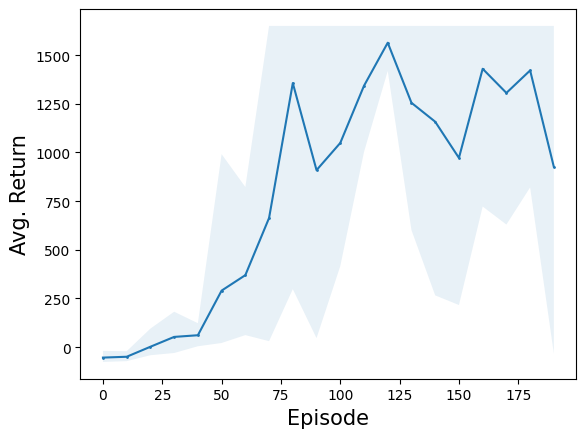

In [8]:
env = FlappyBirdEnv()
num_episodes_train = 200
num_episodes_test = 20



num_seeds = 5
l = num_episodes_train // 10
res = np.zeros((num_seeds, l))
gamma = 0.99


for i in tqdm.tqdm(range(num_seeds)):
    reward_means = []

    
    agent = Agent(input_size=6 , output_size=2,memory_size=10001,batch_size=32, gamma= 0.99,epsilon=0.05,lr=3e-4,replace=50)

    
    for m in range(num_episodes_train):
        env = FlappyBirdEnv()
        state = env.reset()
        
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        terminated = False
        

        
        while not terminated :
            with torch.no_grad():
                action = agent.choose(state).reshape(1, 1)


            
            next_state, reward, terminated, info = env.step(action.item())
            
            reward = torch.tensor([reward])
            if terminated:
                next_state = None
            else:
                next_state = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0)

            
            transition = Transition(state, action, next_state, reward)
            agent.rm.memory.append(transition)

            
            state = next_state

            
            agent.train()

        
        if m % 10 == 0:
            print("Episode: {}".format(m))

            
            G = np.zeros(num_episodes_test)
            for k in range(num_episodes_test):
                g = agent.test()
                G[k] = g

            reward_mean = G.mean()
            reward_sd = G.std()
            print(f"The test reward for episode {m} is {reward_mean} with a standard deviation of {reward_sd}.")
            reward_means.append(reward_mean)

    res[i] = np.array(reward_means)


ks = np.arange(l) * 10
avs = np.mean(res, axis=0)
maxs = np.max(res, axis=0)
mins = np.min(res, axis=0)

plt.fill_between(ks, mins, maxs, alpha=0.1)
plt.plot(ks, avs, '-o', markersize=1)

plt.xlabel('Episode', fontsize=15)
plt.ylabel('Avg. Return', fontsize=15)

In [10]:

env = FlappyBirdEnv()
state = env.reset()


for i in range(500):
    
    if env.render_mode == "rgb_array":
        plt.imshow(env.render())
        display.display(plt.gcf())
        display.clear_output(wait=True)
    else:
        env.render()

   
    state = torch.from_numpy(state).float().unsqueeze(0)
    with torch.no_grad():
        agent.epsilon = 0
        action = agent.choose(state).reshape(1, 1)

    
    state, reward, terminated, info = env.step(action)

   
    if terminated: 
        state = env.reset()


env.close()